In [2]:
import visual_behavior_glm.src.GLM_params as glm_params
import visual_behavior_glm.src.GLM_analysis_tools as gat
import visual_behavior_glm.src.GLM_visualization_tools as gvt
from visual_behavior_glm.src.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
import numpy as np
import os
import copy 
import seaborn as sns

import visual_behavior.plotting as vbp

import plotly.express as px
from sklearn.cluster import KMeans
import umap
import hdbscan # First install the package on the terminal: pip install hdbscan

In [3]:
%matplotlib notebook
%widescreen

# Gather/organize data

## load the results summary for a single GLM version from mongo

In [4]:
rs = gat.retrieve_results(search_dict = {'glm_version': '4_L2_optimize_by_cell'}, results_type='summary')
rs #.sample(10)

_id  index           dropout  \
0        5f22221a7eeb3a3cbb69c983      0              Full   
1        5f22221a7eeb3a3cbb69c984      1         intercept   
2        5f22221a7eeb3a3cbb69c985      2              time   
3        5f22221a7eeb3a3cbb69c986      3         pre_licks   
4        5f22221a7eeb3a3cbb69c987      4        post_licks   
...                           ...    ...               ...   
1365755  5f24621b2ac3d684bf7369e9     27  model_omissions1   
1365756  5f24621b2ac3d684bf7369ea     28    model_timing1D   
1365757  5f24621b2ac3d684bf7369eb     29        all-images   
1365758  5f24621b2ac3d684bf7369ec     30            visual   
1365759  5f24621b2ac3d684bf7369ed     31         beh_model   

         variance_explained  fraction_change_from_full  \
0                  0.229436                   0.000000   
1                  0.229937                   0.002183   
2                  0.229769                   0.001453   
3                  0.229634                   0.000864   
4                  0.227139                  -0.010010   
...                     ...                        ...   
1365755            0.048034                   0.048249   
1365756            0.048441                   0.057133   
1365757            0.039222                  -0.144061   
1365758            0.034920                  -0.237943   
1365759            0.057378                   0.252150   

         absolute_change_from_full  cell_specimen_id  ophys_experiment_id  \
0                         0.000000        1017215561            991852008   
1                         0.000501        1017215561            991852008   
2                         0.000333        1017215561            991852008   
3                         0.000198        1017215561            991852008   
4                        -0.002297        1017215561            991852008   
...                            ...               ...                  ...   
1365755                   0.002211         962642740            808621034   
1365756                   0.002618         962642740            808621034   
1365757                  -0.006601         962642740            808621034   
1365758                  -0.010903         962642740            808621034   
1365759                   0.011554         962642740            808621034   

         ophys_session_id  behavior_session_id  ...  published_at  \
0               991639544            991662910  ...           NaN   
1               991639544            991662910  ...           NaN   
2               991639544            991662910  ...           NaN   
3               991639544            991662910  ...           NaN   
4               991639544            991662910  ...           NaN   
...                   ...                  ...  ...           ...   
1365755         808340530            808432167  ...           NaN   
1365756         808340530            808432167  ...           NaN   
1365757         808340530            808432167  ...           NaN   
1365758         808340530            808432167  ...           NaN   
1365759         808340530            808432167  ...           NaN   

        super_container_id           cre_line session_tags failure_tags  \
0                920877188  Slc17a7-IRES2-Cre          NaN          NaN   
1                920877188  Slc17a7-IRES2-Cre          NaN          NaN   
2                920877188  Slc17a7-IRES2-Cre          NaN          NaN   
3                920877188  Slc17a7-IRES2-Cre          NaN          NaN   
4                920877188  Slc17a7-IRES2-Cre          NaN          NaN   
...                    ...                ...          ...          ...   
1365755          772622653  Slc17a7-IRES2-Cre          NaN          NaN   
1365756          772622653  Slc17a7-IRES2-Cre          NaN          NaN   
1365757          772622653  Slc17a7-IRES2-Cre          NaN          NaN   
1365758          772622653  Slc17a7-IRES2-Cre          NaN          NaN   
1365759  

In [5]:
rs.shape, list(rs['dropout'].unique())

((1365760, 37),
 ['Full',
  'intercept',
  'time',
  'pre_licks',
  'post_licks',
  'pre_lick_bouts',
  'post_lick_bouts',
  'rewards',
  'change',
  'hits',
  'misses',
  'false_alarms',
  'correct_rejects',
  'omissions',
  'image_expectation',
  'running',
  'pupil',
  'image0',
  'image1',
  'image2',
  'image3',
  'image4',
  'image5',
  'image6',
  'image7',
  'model_bias',
  'model_task0',
  'model_omissions1',
  'model_timing1D',
  'all-images',
  'visual',
  'beh_model'])

In [19]:
# rs_now: rs for a single experiment, a single cell
rs_now = rs[np.logical_and(rs['ophys_experiment_id'].values==991852008, rs['cell_specimen_id'].values==1017215561)] #.shape (128, 37) # unique dropout: 32

print(np.shape(rs_now['dropout'].values))
print(list(rs_now['dropout'].values))

(32,)
['Full', 'intercept', 'time', 'pre_licks', 'post_licks', 'pre_lick_bouts', 'post_lick_bouts', 'rewards', 'change', 'hits', 'misses', 'false_alarms', 'correct_rejects', 'omissions', 'image_expectation', 'running', 'pupil', 'image0', 'image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7', 'model_bias', 'model_task0', 'model_omissions1', 'model_timing1D', 'all-images', 'visual', 'beh_model']


# get a list of columns to use for clustering. Defining this list now makes it easier to avoid accidentally clustering on some identifying feature (e.g., cre_line, session_type, etc.)
I'm removing the 'visual' dropout, since it's actually a combination of the omission and all-images dropouts.

In [9]:
cols_for_clustering = list(rs['dropout'].unique())

cols_for_clustering.remove('visual')

cols_for_clustering.remove('model_bias')
cols_for_clustering.remove('model_task0')
cols_for_clustering.remove('model_omissions1')
cols_for_clustering.remove('model_timing1D')
cols_for_clustering.remove('beh_model')

cols_for_clustering.remove('pre_lick_bouts')
cols_for_clustering.remove('post_lick_bouts')

print(np.shape(cols_for_clustering)), cols_for_clustering

(24,)


(None,
 ['Full',
  'intercept',
  'time',
  'pre_licks',
  'post_licks',
  'rewards',
  'change',
  'hits',
  'misses',
  'false_alarms',
  'correct_rejects',
  'omissions',
  'image_expectation',
  'running',
  'pupil',
  'image0',
  'image1',
  'image2',
  'image3',
  'image4',
  'image5',
  'image6',
  'image7',
  'all-images'])

## build a pivoted version of the results summary, using the `fraction_change_from_full` column as the values.

In [10]:
rsp = gat.build_pivoted_results_summary(results_summary=rs, cutoff=0.01, value_to_use='fraction_change_from_full')


In [11]:
# check what fraction of cells are kept after applying the cutoff above.
np.unique(rs['cell_specimen_id']).shape, np.unique(rsp['cell_specimen_id']).shape, np.unique(rsp['cell_specimen_id']).shape[0]/np.unique(rs['cell_specimen_id']).shape[0]

((24656,), (17249,), 0.6995863075924724)

In [12]:
rs.columns, rsp.columns, rs.shape, rsp.shape

(Index(['_id', 'index', 'dropout', 'variance_explained',
        'fraction_change_from_full', 'absolute_change_from_full',
        'cell_specimen_id', 'ophys_experiment_id', 'ophys_session_id',
        'behavior_session_id', 'container_id', 'project_code',
        'container_workflow_state', 'experiment_workflow_state', 'session_name',
        'session_type', 'equipment_name', 'date_of_acquisition',
        'isi_experiment_id', 'specimen_id', 'sex', 'age_in_days',
        'full_genotype', 'reporter_line', 'driver_line', 'imaging_depth',
        'targeted_structure', 'published_at', 'super_container_id', 'cre_line',
        'session_tags', 'failure_tags', 'exposure_number',
        'model_outputs_available', 'location', 'glm_version', 'entry_time_utc',
        'identifier'],
       dtype='object'),
 Index(['identifier', 'Full', 'all-images', 'beh_model', 'change',
        'correct_rejects', 'false_alarms', 'hits', 'image0', 'image1', 'image2',
        'image3', 'image4', 'image5', 'imag

## add a `session_id` column with a numeric value for the session_type (to lump together sessions by order, regardless of image set)

In [253]:
def map_session_types(session_type):
    session_id = int(session_type[6:7])
    if session_id==4:
        session_id=1 # novel
    else:
        session_id=0 # not novel
    return session_id

rsp['session_id'] = rsp['session_type'].map(lambda st:map_session_types(st))


In [254]:
sum(rsp['session_id']==0), sum(rsp['session_id']==1)

(18503, 8292)

## Turn some categorical columns into numerical columns

In [255]:
def make_categorical(df, column):
    df['{}_categorical'.format(column)] = pd.Categorical(df[column], ordered=True).codes

for column in ['cre_line','equipment_name','targeted_structure','session_id']:
    make_categorical(rsp, column)


In [256]:
rsp00 = copy.deepcopy(rsp)

## Merge the behavioral glm df with rsp

In [257]:
# load the behavioral model for each session
# for now we care about 'task_dropout_index'
# task_weight_index is the average value of the task weight for that session. 
# task_dropout_index is the value of the (task dropout - timing dropout). 
# task_only_dropout_index is just task dropout

data = loading.get_behavior_model_summary_table()
# data['task_dropout_index']
data.shape

(333, 64)

In [ ]:
data['']

In [258]:
# compare number of sessions for the behavioral and neural glm models
np.unique(data['ophys_session_id'].values).shape, np.unique(rsp00['ophys_session_id'].values).shape

((333,), (251,))

In [260]:
rsp00.shape

(26795, 68)

In [279]:
# merge rsp and data on session_id
# rsp = rsp.merge(data, on=['ophys_session_id'])
rsp = rsp00.merge(data, on=['ophys_session_id', 'cre_line']) #, how='outer')
rsp.shape

(26517, 130)

In [280]:
list(rsp.columns) #, rsp.shape

['identifier',
 'Full',
 'all-images',
 'beh_model',
 'change',
 'correct_rejects',
 'false_alarms',
 'hits',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'image_expectation',
 'intercept',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'rewards',
 'running',
 'time',
 'visual',
 'cell_specimen_id',
 'ophys_experiment_id_x',
 'ophys_session_id',
 'behavior_session_id_x',
 'container_id_x',
 'project_code_x',
 'container_workflow_state',
 'experiment_workflow_state',
 'session_name',
 'session_type_x',
 'equipment_name_x',
 'date_of_acquisition_x',
 'isi_experiment_id',
 'specimen_id_x',
 'sex_x',
 'age_in_days_x',
 'full_genotype_x',
 'reporter_line_x',
 'driver_line_x',
 'imaging_depth_x',
 'targeted_structure',
 'published_at',
 'super_container_id',
 'cre_line',
 'session_tags',
 'failure_tags',
 'exposure_number'

In [283]:
rsp.iloc[1298]['ophys_experiment_id_x'], rsp.iloc[1298]['ophys_experiment_id_y']

(795948257, '[795948257]')

In [286]:
rsp.drop_duplicates(columns=['ophys_session_id', 'cre_line'],inplace=True)

TypeError: drop_duplicates() got an unexpected keyword argument 'columns'

In [294]:
rsp[rsp['ophys_experiment_id_x'].values==795948257][['cell_specimen_id', 'beh_model']]

cell_specimen_id  beh_model
1203         962560014   0.000312
1204         962560121   0.005918
1205         962560308   0.004770
1206         962560549   0.000380
1207         962560674   0.003564
...                ...        ...
1394         962620843   0.001004
1395         962620878   0.003311
1396         962620942   0.004470
1397         962620969   0.003397
1398         962621000   0.000280

[196 rows x 2 columns]

## Redefine cols_for_clustering
### add some features from behavioral glm to rsp 

In [179]:
# make sure to not add features that get repeated across cells (eg task_dropout_index will be repeated for all cells of the same session)
# cols_for_clustering.append('task_dropout_index')
# np.shape(cols_for_clustering), cols_for_clustering

# Dimensionality reduction and clustering
So many more things to try here. This is just a start.

## UMAP

In [295]:
neigh_vals = np.concatenate(([5, 10, 15, 50], np.arange(200, int(rsp.shape[0]/10), 500)))
print(neigh_vals)

[   5   10   15   50  200  700 1200 1700 2200]


In [296]:
rsp.shape, rsp[cols_for_clustering].shape

((26517, 130), (26517, 31))

In [297]:
n_components = 15 # dimensions of original data: np.shape(cols_for_clustering)[0]

mindist = 0.1 # default: .1 
neigh = neigh_vals[0]

reducer = umap.UMAP(n_components=n_components, min_dist = mindist, n_neighbors = neigh)
embedding = reducer.fit_transform(rsp[cols_for_clustering])
print(embedding.shape)

# reducer_2d = umap.UMAP(n_components=2)
# reducer_3d = umap.UMAP(n_components=3)

# embedding_2d = reducer_2d.fit_transform(rsp[cols_for_clustering])
# embedding_3d = reducer_3d.fit_transform(rsp[cols_for_clustering])

# keep these dimensions for plotting
rsp['umap_3d_embedding_0'] = embedding[:, 0]
rsp['umap_3d_embedding_1'] = embedding[:, 1]
rsp['umap_3d_embedding_2'] = embedding[:, 2]

# rsp['umap_2d_embedding_0'] = embedding_2d[:, 0]
# rsp['umap_2d_embedding_1'] = embedding_2d[:, 1]

(26517, 15)


In [298]:
embedding.shape, neigh, mindist

((26517, 15), 5, 0)

## k-means clustering on 3d umap


In [299]:
kmeans = KMeans(n_clusters=20)
umap_cols = ['umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']
rsp['clusterer_labels'] = kmeans.fit_predict(rsp[umap_cols])
rsp['clusterer_labels'].value_counts()

kmeans = KMeans(n_clusters=20)
umap_cols = ['umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']
rsp['clusterer_labels'] = kmeans.fit_predict(rsp[umap_cols])
rsp['clusterer_labels'].value_counts()

0     2306
8     2038
5     1941
19    1707
12    1674
16    1524
17    1493
14    1436
11    1352
4     1347
3     1294
10    1251
2     1234
13    1228
7      939
15     900
1      777
9      775
6      657
18     644
Name: clusterer_labels, dtype: int64

## hdbscan clustrering

In [304]:
min_cluster_size = 100 #50 # (default=5)
min_samples = 10 #min_cluster_size #18 # default: same as min_cluster_size

clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples) #(min_cluster_size=9, gen_min_span_tree=True)
clusterer.fit(embedding) # rsp[umap_cols]
# clusterer.labels_ # cluster_labels = clusterer.fit_predict(embedding)
# clusterer.probabilities_
rsp['clusterer_labels'] = clusterer.labels_
val_per_clust = rsp['clusterer_labels'].value_counts().values # number of points per cluster

In [305]:
# fract_per_clust = [np.mean(clusterer.labels_ == np.unique(clusterer.labels_)[i]) for i in range(len(np.unique(clusterer.labels_)))]
print(len(np.unique(clusterer.labels_)))
# noise points
print(sum(clusterer.labels_ == -1), np.mean(clusterer.labels_ == -1))

rsp['clusterer_labels'].value_counts()


6
54 0.002036429460346193


 4    25125
 0      766
 3      245
 2      182
 1      145
-1       54
Name: clusterer_labels, dtype: int64

In [ ]:
# evaluate clustering results

print(val_per_clust.shape)
print(np.sort(val_per_clust))

# number of clusters with <th_neur neurons in them.
th_n = 20 # we dont want to have less than 20 neurons in a cluster, maybe.
print(sum(val_per_clust < th_n), np.mean(val_per_clust < th_n))

# noise points
print(sum(clusterer.labels_ == -1), np.mean(clusterer.labels_ == -1))

<IPython.core.display.Javascript object>


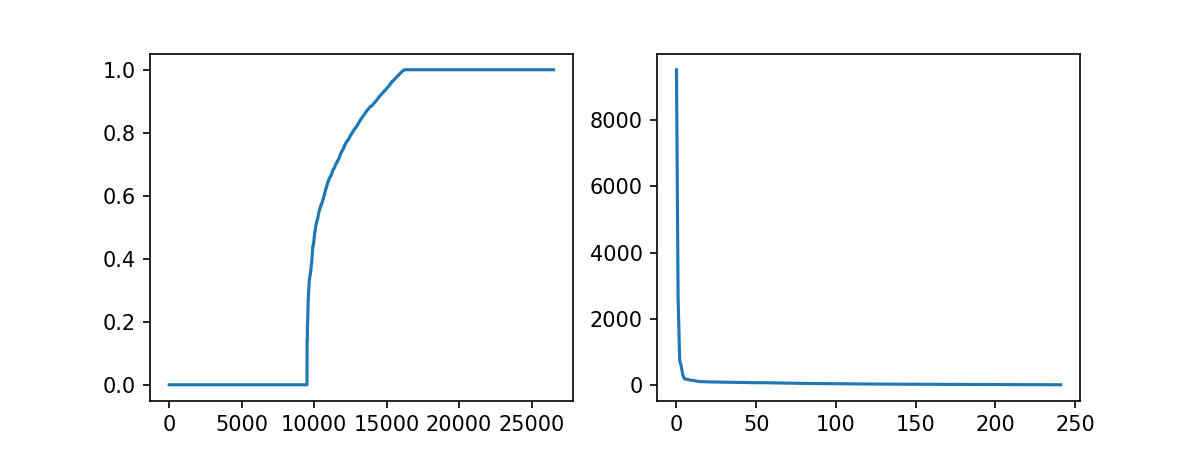

[0.         0.12261092 0.12453934 ... 0.99984457 0.99996077 1.        ]


In [198]:
# plot clusterer probabilities and number of cells in each label.

plt.figure(figsize=(8,3))

plt.subplot(121), plt.plot(np.sort(clusterer.probabilities_))
plt.subplot(122), plt.plot(val_per_clust)
print(np.unique(clusterer.probabilities_))

In [199]:
rsp[cols_for_clustering]

Full  intercept      time  pre_licks  post_licks  pre_lick_bouts  \
0       0.0   0.000913 -0.001004   0.014952   -0.005937        0.011424   
1       0.0   0.000081  0.000434   0.037226    0.003103        0.031004   
2       0.0  -0.002156  0.004291   0.008150    0.002149        0.003036   
3       0.0   0.003374  0.002495   0.004108    0.000574        0.004443   
4       0.0   0.000038  0.000490   0.030949    0.005812        0.031873   
...     ...        ...       ...        ...         ...             ...   
26512   0.0  -0.013133  0.028642   0.170683    0.012142        0.100268   
26513   0.0  -0.000912 -0.020402   0.157746    0.043114        0.107631   
26514   0.0  -0.006349 -0.057415   0.005179   -0.001993        0.002772   
26515   0.0  -0.000300 -0.003067   0.166319    0.040880        0.117245   
26516   0.0  -0.001291  0.004683   0.019762    0.003029        0.002511   

       post_lick_bouts   rewards    change      hits  ...    image4    image5  \
0             0.007587  0.010710  0.000581  0.005280  ...  0.003621 -0.001186   
1             0.001011  0.032333  0.000530  0.003584  ...  0.002283 -0.018611   
2            -0.004966 -0.000740  0.000224  0.001834  ...  0.000302 -0.012279   
3            -0.001018  0.011120  0.000232  0.002990  ...  0.001615 -0.021775   
4             0.010330  0.021468  0.000713  0.006967  ...  0.003739  0.002454   
...                ...       ...       ...       ...  ...       ...       ...   
26512         0.022004  0.096974  0.006062  0.058348  ...  0.010657  0.016359   
26513         0.027403  0.070162  0.004174  0.024597  ...  0.001583  0.006884   
26514         0.005182  0.017730  0.000775  0.004339  ... -0.000970 -0.000321   
26515         0.015220  0.064248  0.003886  0.039209  ... -0.061918  0.016950   
26516        -0.002331  0.011392  0.000625  0.005053  ... -0.030594  0.001062   

         image6    image7  model_bias  model_task0  model_omissions1  \
0     -0.026248  0.002645   -0.001924    -0.000538          0.000501   
1      0.002152  0.002657    0.000728     0.000856          0.001277   
2      0.008475  0.001058    0.010619    -0.001927          0.029392   
3      0.000046  0.002221    0.014580     0.005393          0.006673   
4     -0.000550  0.008610   -0.000054     0.000657          0.001188   
...         ...       ...         ...          ...               ...   
26512 -0.052912 -0.017866   -0.187010     0.019241         -0.042443   
26513 -0.065082  0.001343    0.004711     0.001660         -0.006249   
26514 -0.008589 -0.000520    0.000506    -0.001359         -0.102949   
26515  0.010580  0.016852    0.004984    -0.001372         -0.013852   
26516  0.001363 -0.003418    0.004363     0.001219          0.003764   

       model_timing1D  all-images  beh_model  
0            0.000135   -0.140223  -0.001848  
1            0.002049   -0.155019   0.004636  
2            0.021750   -0.210215   0.062499  
3           -0.001058   -0.368535   0.021722  
4           -0.001699   -0.089674   0.000823  
...               ...         ...        ...  
26512        0.004689   -0.673633   0.086221  
26513        0.005738   -0.485011   0.007001  
26514        0.021117   -1.118526   0.042506  
26515        0.002127   -0.541743   0.006398  
26516        0.011824   -0.277435   0.013547  

[26517 rows x 31 columns]

## visualize in 2d using matplotlib

<IPython.core.display.Javascript object>


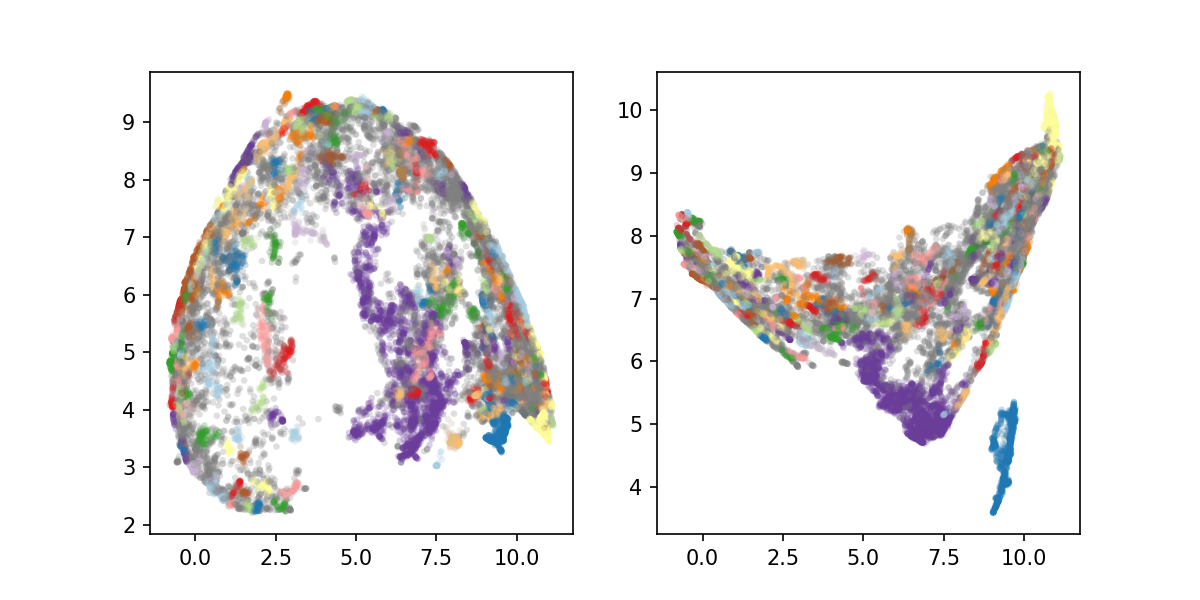

In [203]:
color_palette = sns.color_palette('Paired', len(rsp['clusterer_labels'].unique()))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(rsp['umap_3d_embedding_0'], rsp['umap_3d_embedding_1'], s=10, linewidth=0, c=cluster_member_colors, alpha=0.25)

plt.subplot(122)
plt.scatter(rsp['umap_3d_embedding_0'], rsp['umap_3d_embedding_2'], s=10, linewidth=0, c=cluster_member_colors, alpha=0.25)



<IPython.core.display.Javascript object>


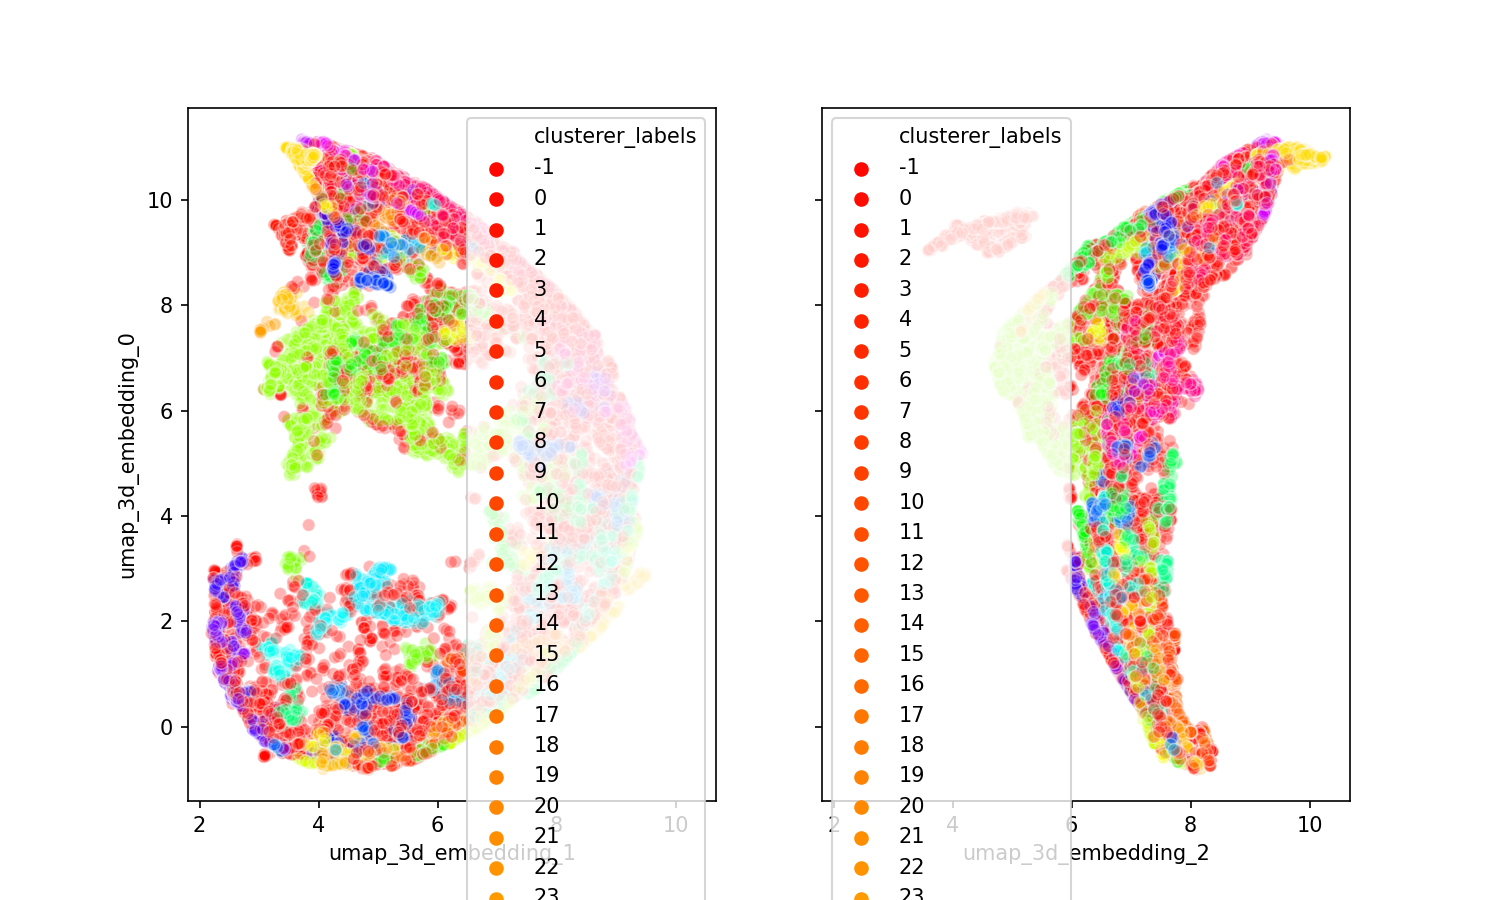

In [201]:
fig,ax=plt.subplots(1,2,figsize=(10,6),sharey=True,sharex=True)
sns.scatterplot(
    x='umap_3d_embedding_1', 
    y='umap_3d_embedding_0',
    hue='clusterer_labels',
    palette=sns.color_palette("hsv", len(rsp['clusterer_labels'].unique())),
    data=rsp,
    legend='full',
    alpha=0.3,
    ax=ax[0],
)
sns.scatterplot(
    x='umap_3d_embedding_2', 
    y='umap_3d_embedding_0',
    hue='clusterer_labels',
    palette=sns.color_palette("hsv", len(rsp['clusterer_labels'].unique())),
    data=rsp,
    legend='full',
    alpha=0.3,
    ax=ax[1],
)

## visualize in 3d using plotly

In [204]:
fig = px.scatter_3d(
    rsp, 
    x='umap_3d_embedding_0', 
    y='umap_3d_embedding_1', 
    z='umap_3d_embedding_2',
    color='clusterer_labels',
    color_continuous_scale='hsv',
)

fig.update_traces(marker=dict(size=3))

# optional view positioning parameters (I don't really understand these, just toying with them to get a view I like!)
camera = dict(
    up=dict(x=3, y=1.75, z=0.25),
    eye=dict(x=1.5, y=1.5, z=-0.2)
)

fig.update_layout(
    scene_camera=camera,
    margin=dict(l=30, r=30, t=10, b=10),
    width=1200,
    height=1000,
)
# fig.write_html("/home/dougo/code/dougollerenshaw.github.io/figures_to_share/2020.08.21_k_means_on_umap.html")
fig.show()

# A little bit of prep for plotting

## first define the dominant dropout in each cluster

In [205]:
rsp_bc = copy.deepcopy(rsp)
rsp_bc.shape

(26517, 134)

In [206]:
# identify dominant dropouts for each cluster
gat.identify_dominant_dropouts(rsp, cluster_column_name='clusterer_labels', cols_to_search=cols_for_clustering)

In [207]:
rsp.shape, rsp.columns

((26517, 136),
 Index(['identifier', 'Full', 'all-images', 'beh_model', 'change',
        'correct_rejects', 'false_alarms', 'hits', 'image0', 'image1',
        ...
        'trained_B', 'trial_hit_fraction', 'trial_hit_fraction_1st',
        'trial_hit_fraction_2nd', 'umap_3d_embedding_0', 'umap_3d_embedding_1',
        'umap_3d_embedding_2', 'clusterer_labels', 'dominant_dropout',
        'dominant_dropout_median'],
       dtype='object', length=136))

In [208]:
for column in ['dominant_dropout']:
    make_categorical(rsp, column)

## only get those rsp rows that have non-noise cluster values

In [209]:
rsp['clusterer_labels'].value_counts()

-1      9508
 57     2641
 1       755
 34      570
 228     304
        ... 
 188      20
 52       20
 184      20
 72       20
 145      20
Name: clusterer_labels, Length: 242, dtype: int64

In [210]:
rspall = copy.deepcopy(rsp)
rspall.shape

(26517, 137)

In [211]:
# only get those rsp rows that have non-noise cluster values

rsp = rspall[rspall['clusterer_labels'] != -1]
rsp.shape

(17009, 137)

## define heatmap parameters
lots here, but there are lots of options!

In [212]:
cols_to_plot = [
    'clusterer_labels',      
    'all-images', 
    'omissions', 
    'pupil', 
    'running',
    'cre_line_categorical', 
    'dominant_dropout_categorical',
    'session_id_categorical', 
#    'equipment_name_categorical',
#    'targeted_structure_categorical',
#    'imaging_depth',
    'task_dropout_index',  
]

# make sure there's a heatmap definition for every column, otherwise the column will plot without a heatmap!
heatmap_defs = [
    {
        'columns':cols_to_plot[1:5],
        'cbar_label':'fraction change\nin var explained',
        'cbar_ticks':[-1,0,1],
        'vmin':-1,
        'vmax':1,
        'cmap':'bwr',
    },
    {
        'columns':['cre_line_categorical'],
        'cbar_label':'cre_line',
        'cbar_ticks':[0,1,2],
        'cbar_ticklabels':np.sort(np.unique(rsp['cre_line'])),
        'vmin':-0.5,
        'vmax':2.5,
        'cmap':sns.color_palette("hls", 3),
    },    
    {
        'columns':['dominant_dropout_categorical'],
        'cbar_label':'dominant_dropout_categorical',
        'cbar_ticks':np.arange(len(rsp['dominant_dropout_categorical'].unique())),
        'cbar_ticklabels':np.sort(np.unique(rsp['dominant_dropout'])),
        'vmin':-0.5,
        'vmax':len(rsp['dominant_dropout_categorical'].unique())-0.5,
        'cmap':sns.color_palette("hls", len(rsp['dominant_dropout_categorical'].unique())),

    },
    {
        'columns':['session_id_categorical'],
        'cbar_label':'session ID',
        'cbar_ticks':[0,1], #[0,1,2,3],
        'cbar_ticklabels':['familiar', 'novel'], #[1,3,4,6],
        'vmin':-0.5,
        'vmax':1.5, #3.5,
        'cmap':sns.color_palette("Dark2", 2), # 4
    },
    {
        'columns':['clusterer_labels'],
        'cbar_label':'k-means label',
        'cbar_ticks':np.arange(min(rsp['clusterer_labels'].unique()),len(rsp['clusterer_labels'].unique()),2),
        'vmin':min(rsp['clusterer_labels'].unique()),
        'vmax':len(rsp['clusterer_labels'].unique())-1,
        'cmap':sns.color_palette("hsv", len(rsp['clusterer_labels'].unique())),
    },
#     {
#         'columns':['equipment_name_categorical'],
#         'cbar_label':'equipment name',
#         'cbar_ticks':np.arange(len(rsp['equipment_name_categorical'].unique())),
#         'cbar_ticklabels':np.sort(np.unique(rsp['equipment_name'])),
#         'vmin':-0.5,
#         'vmax':len(rsp['equipment_name_categorical'].unique())-0.5,
#         'cmap':sns.color_palette("hls", len(rsp['equipment_name_categorical'].unique())),
#     },
#     {
#         'columns':['targeted_structure_categorical'],
#         'cbar_label':'targeted structure',
#         'cbar_ticks':np.arange(len(rsp['targeted_structure_categorical'].unique())),
#         'cbar_ticklabels':np.sort(np.unique(rsp['targeted_structure'])),
#         'vmin':-0.5,
#         'vmax':len(rsp['targeted_structure'].unique())-0.5,
#         'cmap':sns.color_palette("hls", len(rsp['targeted_structure'].unique())),
#     },
#     {
#         'columns':['imaging_depth'],
#         'cbar_label':'imaging_depth',
#         'cbar_ticks':[0,100,200,300,400],
#         'vmin':0,
#         'vmax':400,
#         'cmap':'magma',
#     },
    {
        'columns':['task_dropout_index'],
        'cbar_label':'task_dropout_index',
        'cmap':'inferno',
    },    
]

In [230]:
rsp.iloc[10]['ophys_experiment_id_x'] #rsp[rsp['ophys_session_id']==787661032]

1003122317

# Make heatmaps, sort by whatever we want
Note that it only makes sense to nest sorting values for categorical data. Any sorting value that follows a continuous variable will not have any effect.

## First sort by dominant dropout, the median value of the dominant dropout (for cases with multiple clusters sharing the same dominant dropout), then cre_line, session_id, imaging_depth

<IPython.core.display.Javascript object>


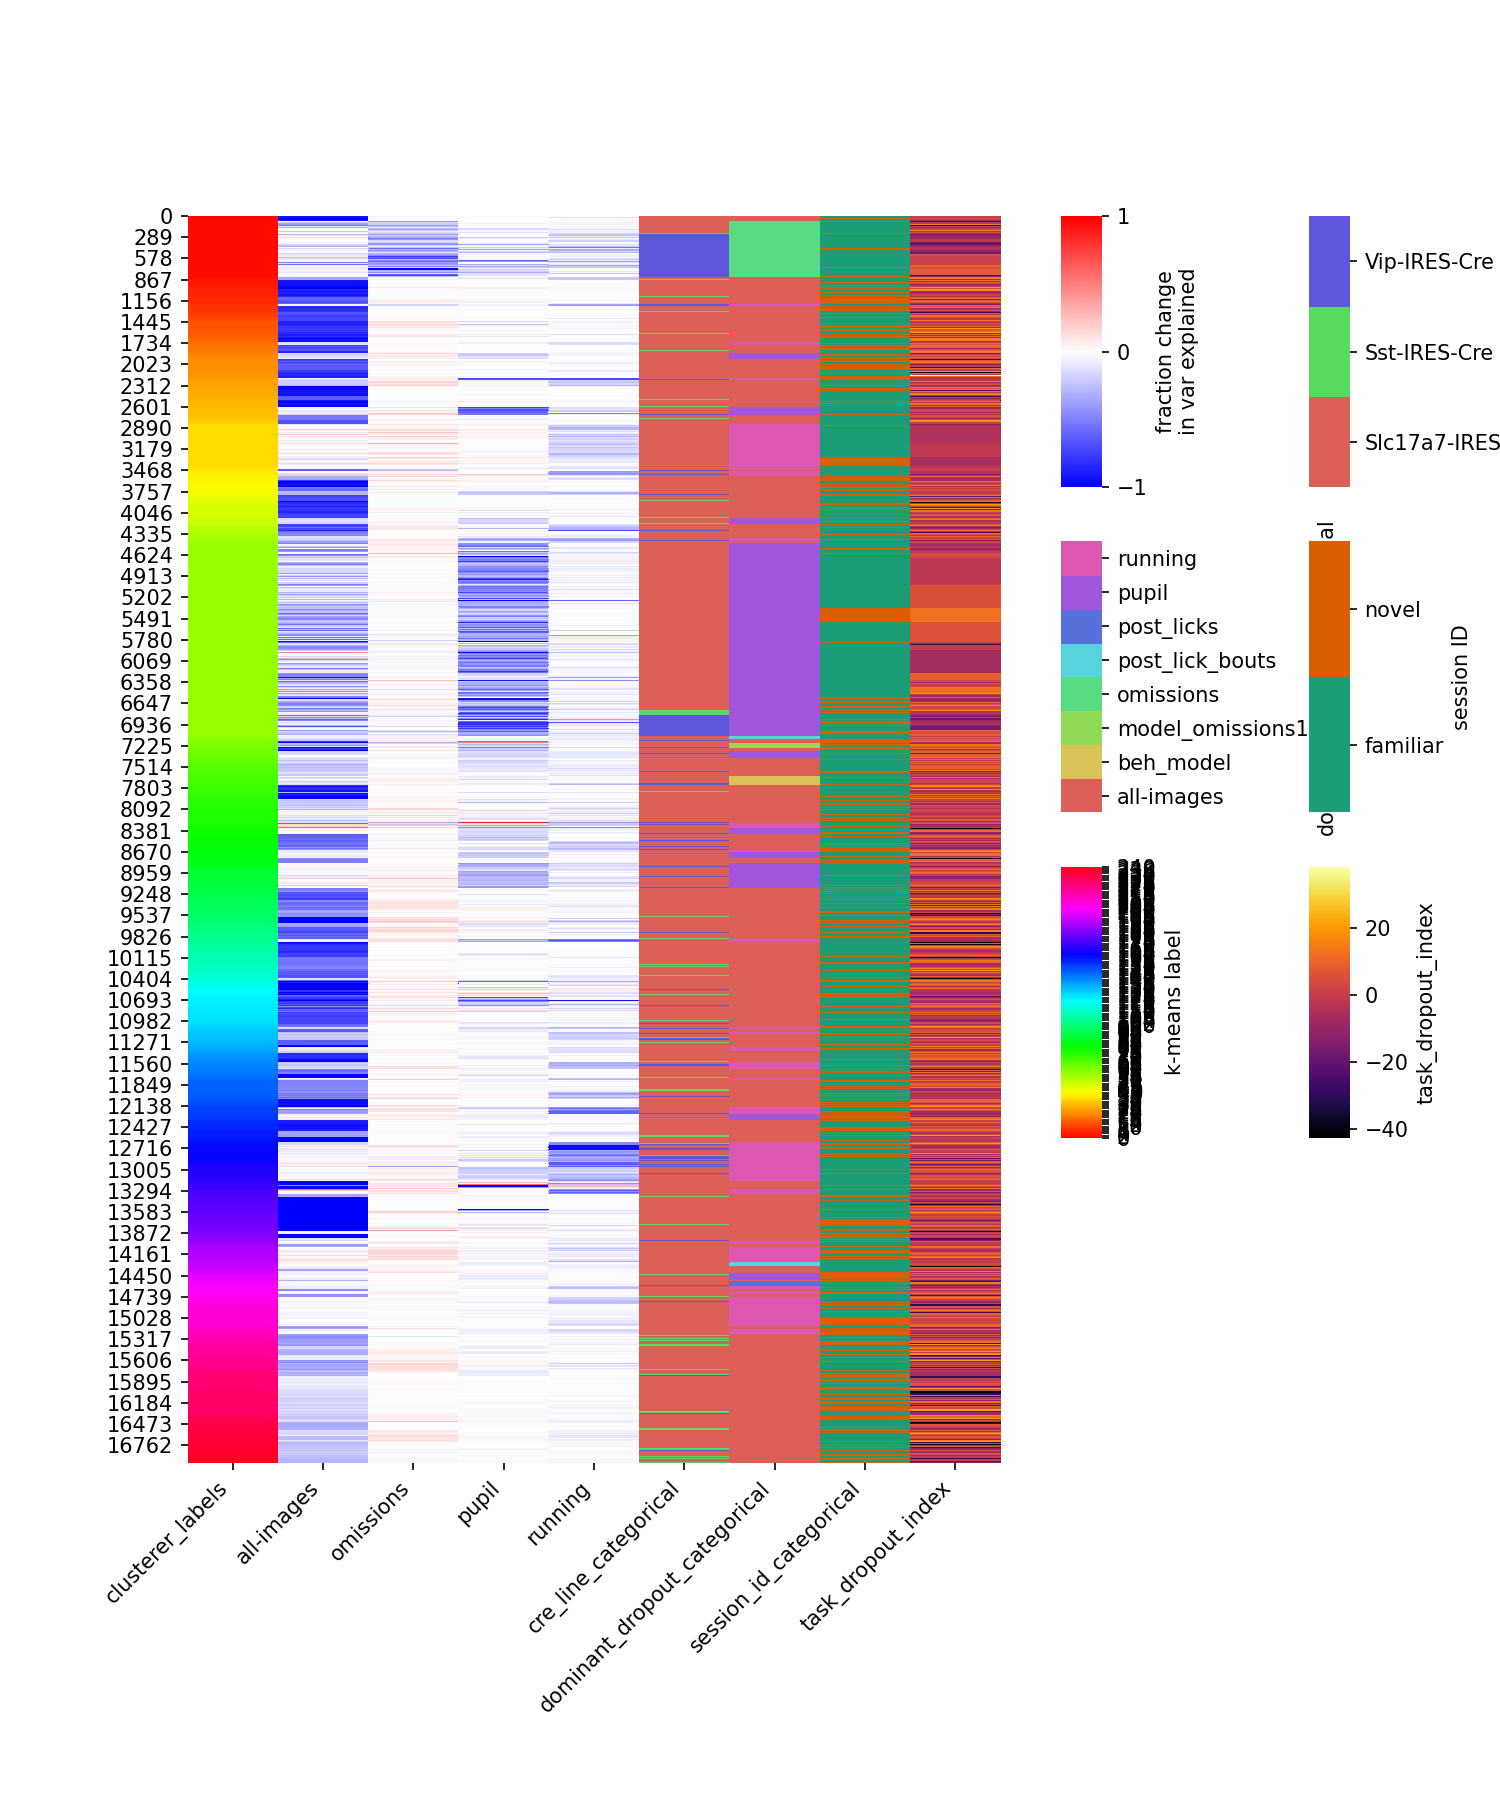

In [213]:
# sort_order = ['task_dropout_index', 'dominant_dropout','dominant_dropout_median','cre_line_categorical']
# sort_order = ['dominant_dropout','dominant_dropout_median','cre_line_categorical','session_id_categorical','imaging_depth',]
sort_order = ['clusterer_labels', 'dominant_dropout','dominant_dropout_median','cre_line_categorical']
# sort_order = ['clusterer_labels', 'task_dropout_index']
# sort_order = ['task_dropout_index']

sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)

# for idx,row in sorted_data.query('cluster_transition').iterrows():
#     axes['heatmap'].axhline(idx,color='black')

## add pie charts for each cluster
Doc for pandas pie charts: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.pie.html

Note: It'd probably be better to normalize the values in the pie charts by their total number in in the dataset. For example, since there are far more Slc cells, they dominate every pie chart.

In [215]:
sorted_data['task_dropout_index'].values

array([ -0.60300736,  -0.60300736, -10.73696914, ..., -12.86498547,
       -15.39098009, -13.06888477])

In [ ]:
# bin a feature, and then for each bin look at the distribution of a bunch of other features

topc = sorted_data['task_dropout_index'].values
nbins = 2

r = np.max(topc) - np.min(topc)
binEvery = r/float(nbins)
# set bins
bn = np.arange(np.min(topc), np.max(topc), binEvery)
bn[-1] = np.max(topc)#+binEvery/10. # unlike digitize, histogram doesn't count the right most value

hist_inds = np.digitize(topc, bn)

# hist, bin_edges = np.histogram(topc, bins=bn)
# hist = hist/float(np.sum(hist))    


#### continuous parameters    
# now for each bin, look at the distribution of a given parameter
parameters = ['all-images', 'omissions', 'pupil', 'running', 'imaging_depth']

for row in range(len(hist_inds)):
    sd_this_bin = sorted_data[hist_inds == row]
    
    for col,parameter in enumerate(parameters):
        
        ax[row,col].hist(
            sd_this_bin[parameter],
            bins=np.arange(0,400,50),
            density=True
        )

        # set titles, make first row title different
        if row == 0:
            ax[row, col].set_title('parameter = {}\nbin = {}'.format(parameter, row))
        else:
            ax[row, col].set_title('row = {}'.format(row))


#### categorical parameters    
# now for each bin, look at the pie chart of a given parameter
parameters = [['cre_line','session_id','targeted_structure', 'clusterer_labels']]

for row in range(len(hist_inds)):
    sd_this_bin = sorted_data[hist_inds == row]
    
    for col,parameter in enumerate(parameters):
        
        # build a dataframe of value counts for the pie chart (there's probably a better way!)
        DOUBLE check below
        df = pd.DataFrame(sd_this_bin[parameter].value_counts()).sort_index()
        plot = df.plot.pie(
            y = parameter, 
            ax = ax[row,col],
            legend = False
        )
        ax[row,col].set_ylabel('')

        # set titles, make first row title different
        if row == 0:
            ax[row, col].set_title('parameter = {}\nbin = {}'.format(parameter, row))
        else:
            ax[row, col].set_title('row = {}'.format(row))
            

<IPython.core.display.Javascript object>


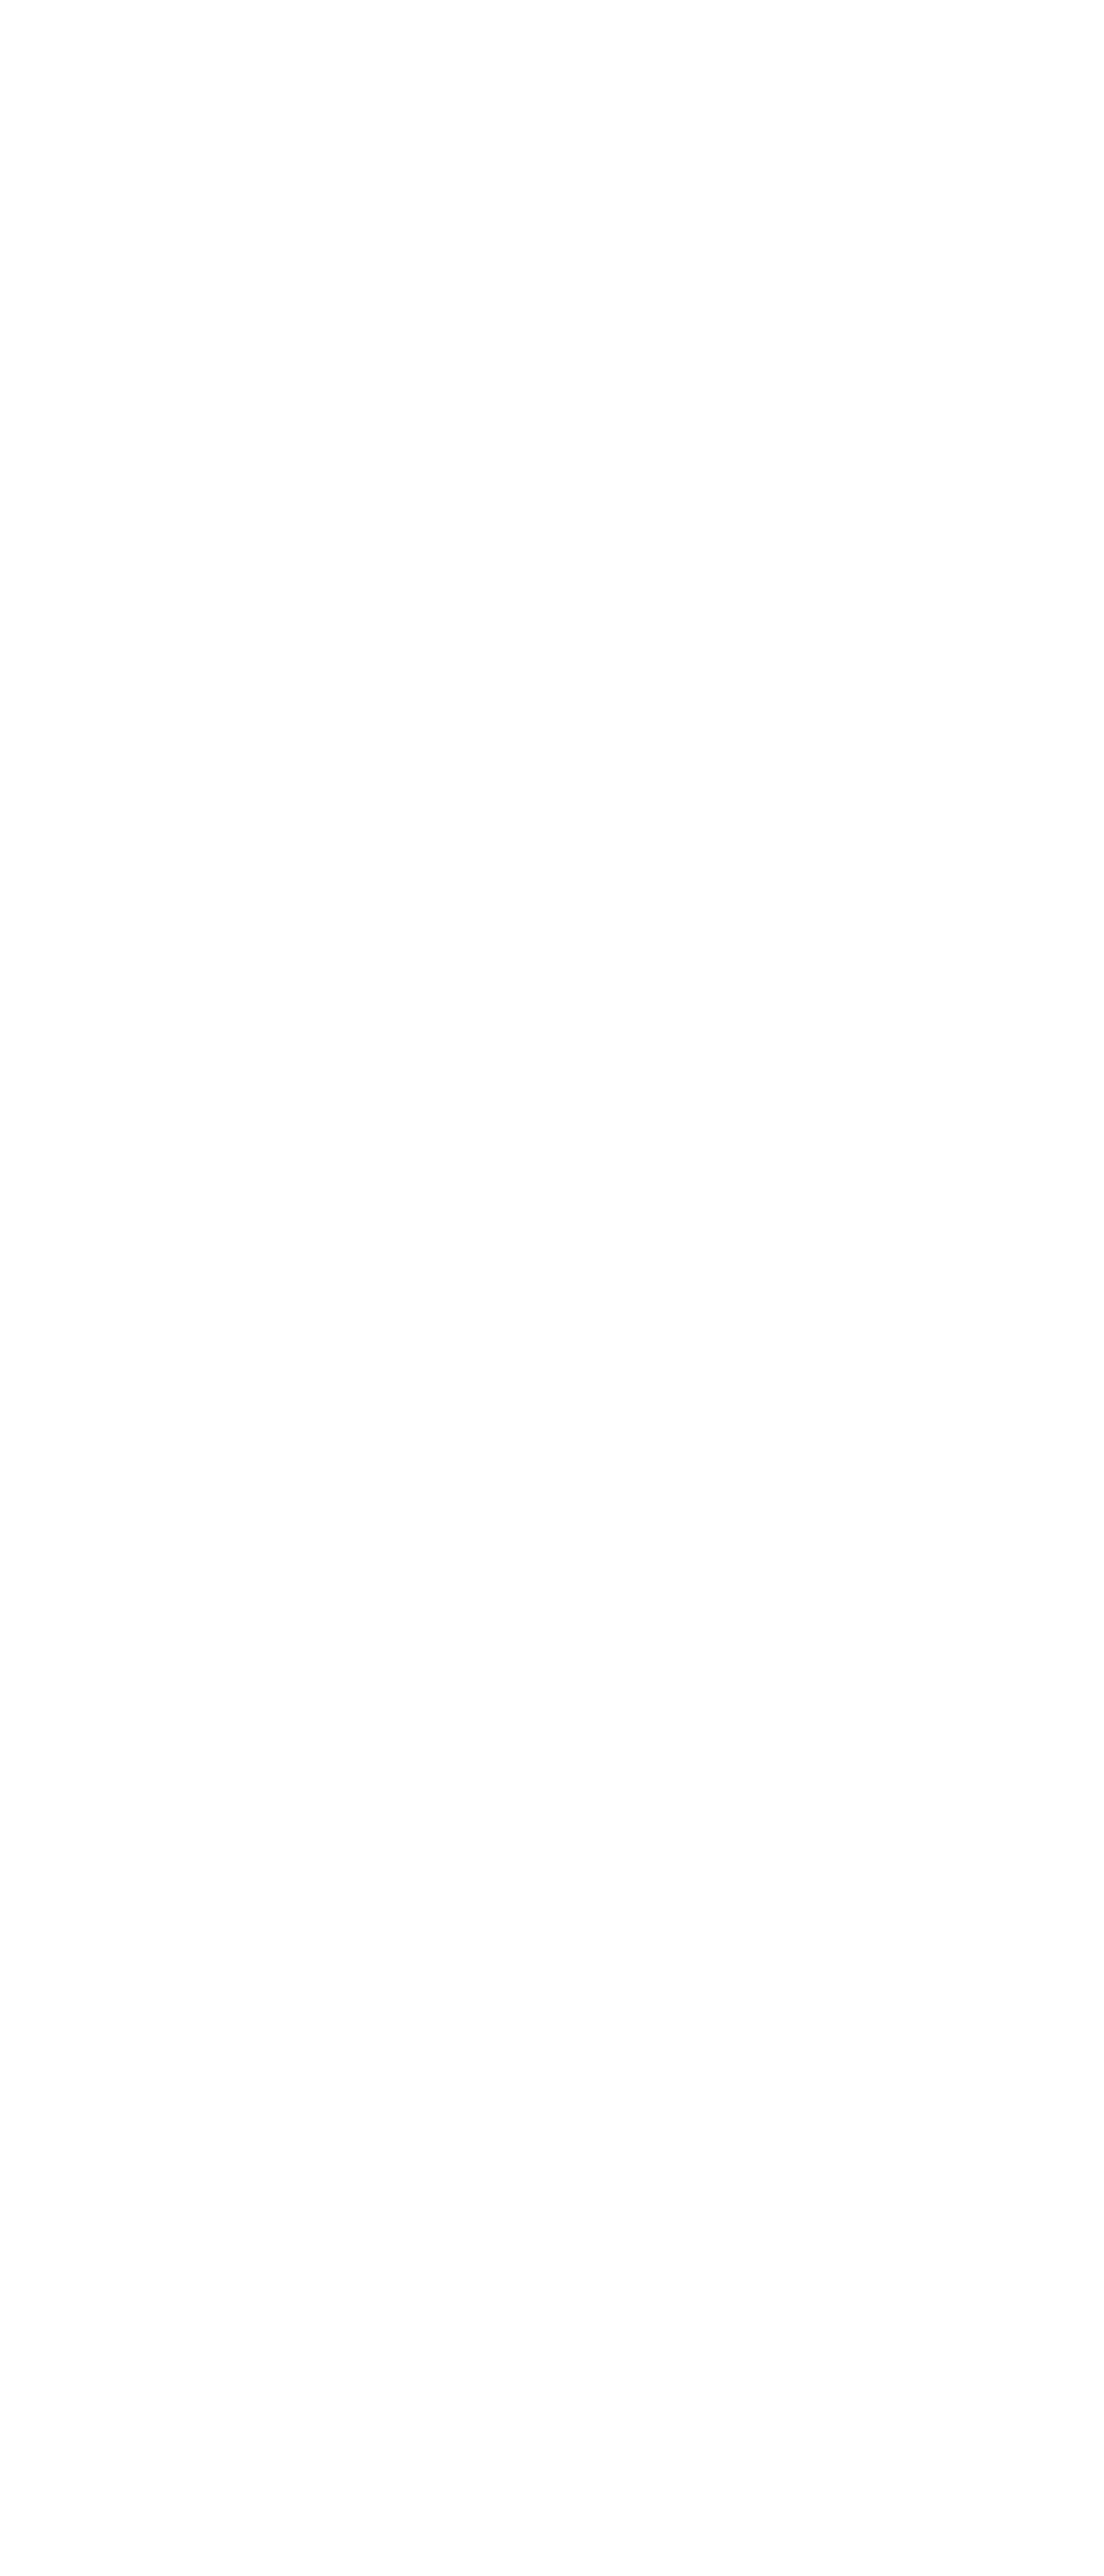

NameError: name 'sorted_data' is not defined

In [5]:
# For each cluster id, we compute a given parameter's distribution; e.g. for cluster_id 0, we compute the number of cells that took each value of "session_id"

fig,ax = plt.subplots(20,4,figsize=(15,35))

parameters = ['cre_line','session_id','targeted_structure', 'imaging_depth']

for row,cluster_id in enumerate(sorted_data['clusterer_labels'].unique()):
    for col,parameter in enumerate(parameters):
        # make a histogram of imaging depths
        if parameter == 'imaging_depth':
            ax[row,col].hist(
                sorted_data.query('clusterer_labels == @cluster_id')['imaging_depth'],
                bins=np.arange(0,400,50),
                density=True
            )
            
        # make a pie chart for the rest
        else:
            # build a dataframe of value counts for the pie chart (there's probably a better way!)
            df = pd.DataFrame(sorted_data.query('clusterer_labels == @cluster_id')[parameter].value_counts()).sort_index()
            plot = df.plot.pie(
                y = parameter, 
                ax = ax[row,col],
                legend = False
            )
            ax[row,col].set_ylabel('')
        
        # set titles, make first row title different
        if row == 0:
            ax[row, col].set_title('parameter = {}\ncluster ID = {}'.format(parameter, cluster_id))
        else:
            ax[row, col].set_title('cluster ID = {}'.format(cluster_id))
            
            
fig.tight_layout()

## another sorting, with imaging_depth being the emphasis

In [214]:
sort_order = ['dominant_dropout','dominant_dropout_median','imaging_depth','cre_line_categorical','session_id_categorical']
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

KeyError: 'imaging_depth'

## and another sorting, with session_id being the emphasis

<IPython.core.display.Javascript object>


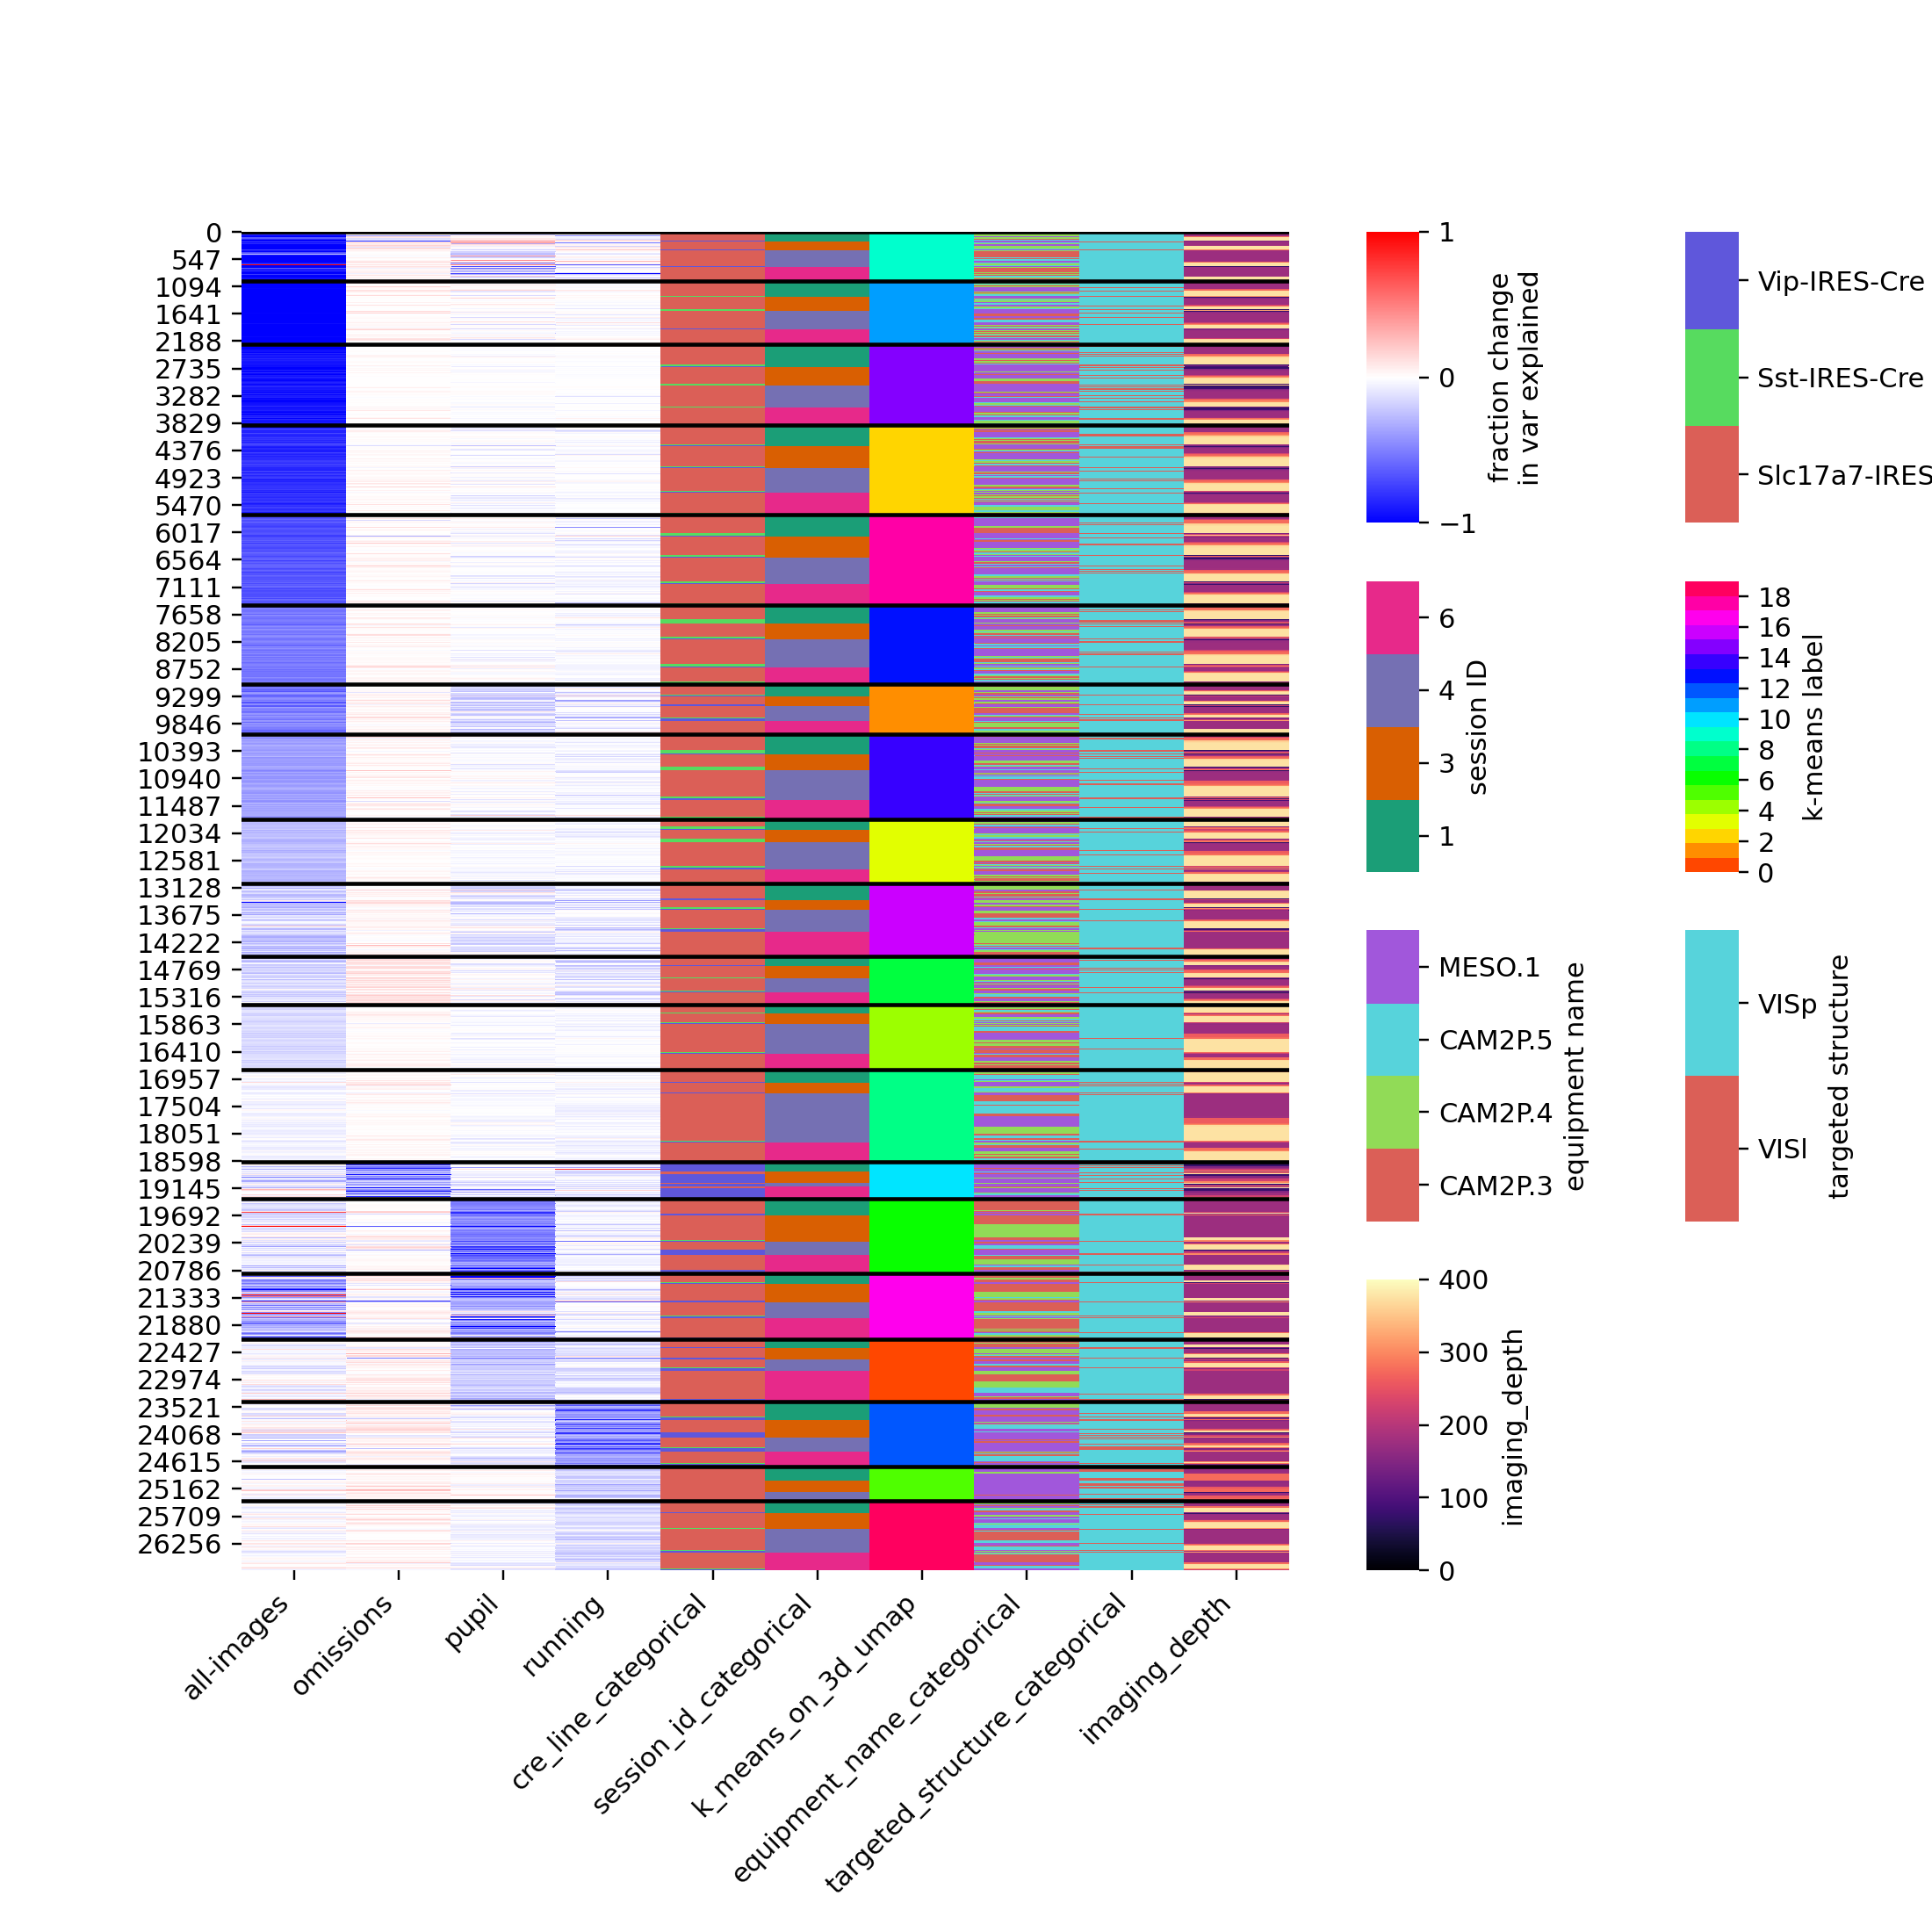

In [41]:
sort_order = ['dominant_dropout','dominant_dropout_median','session_id_categorical','cre_line_categorical','imaging_depth',]
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,10), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

## sort by structure after dropout

<IPython.core.display.Javascript object>


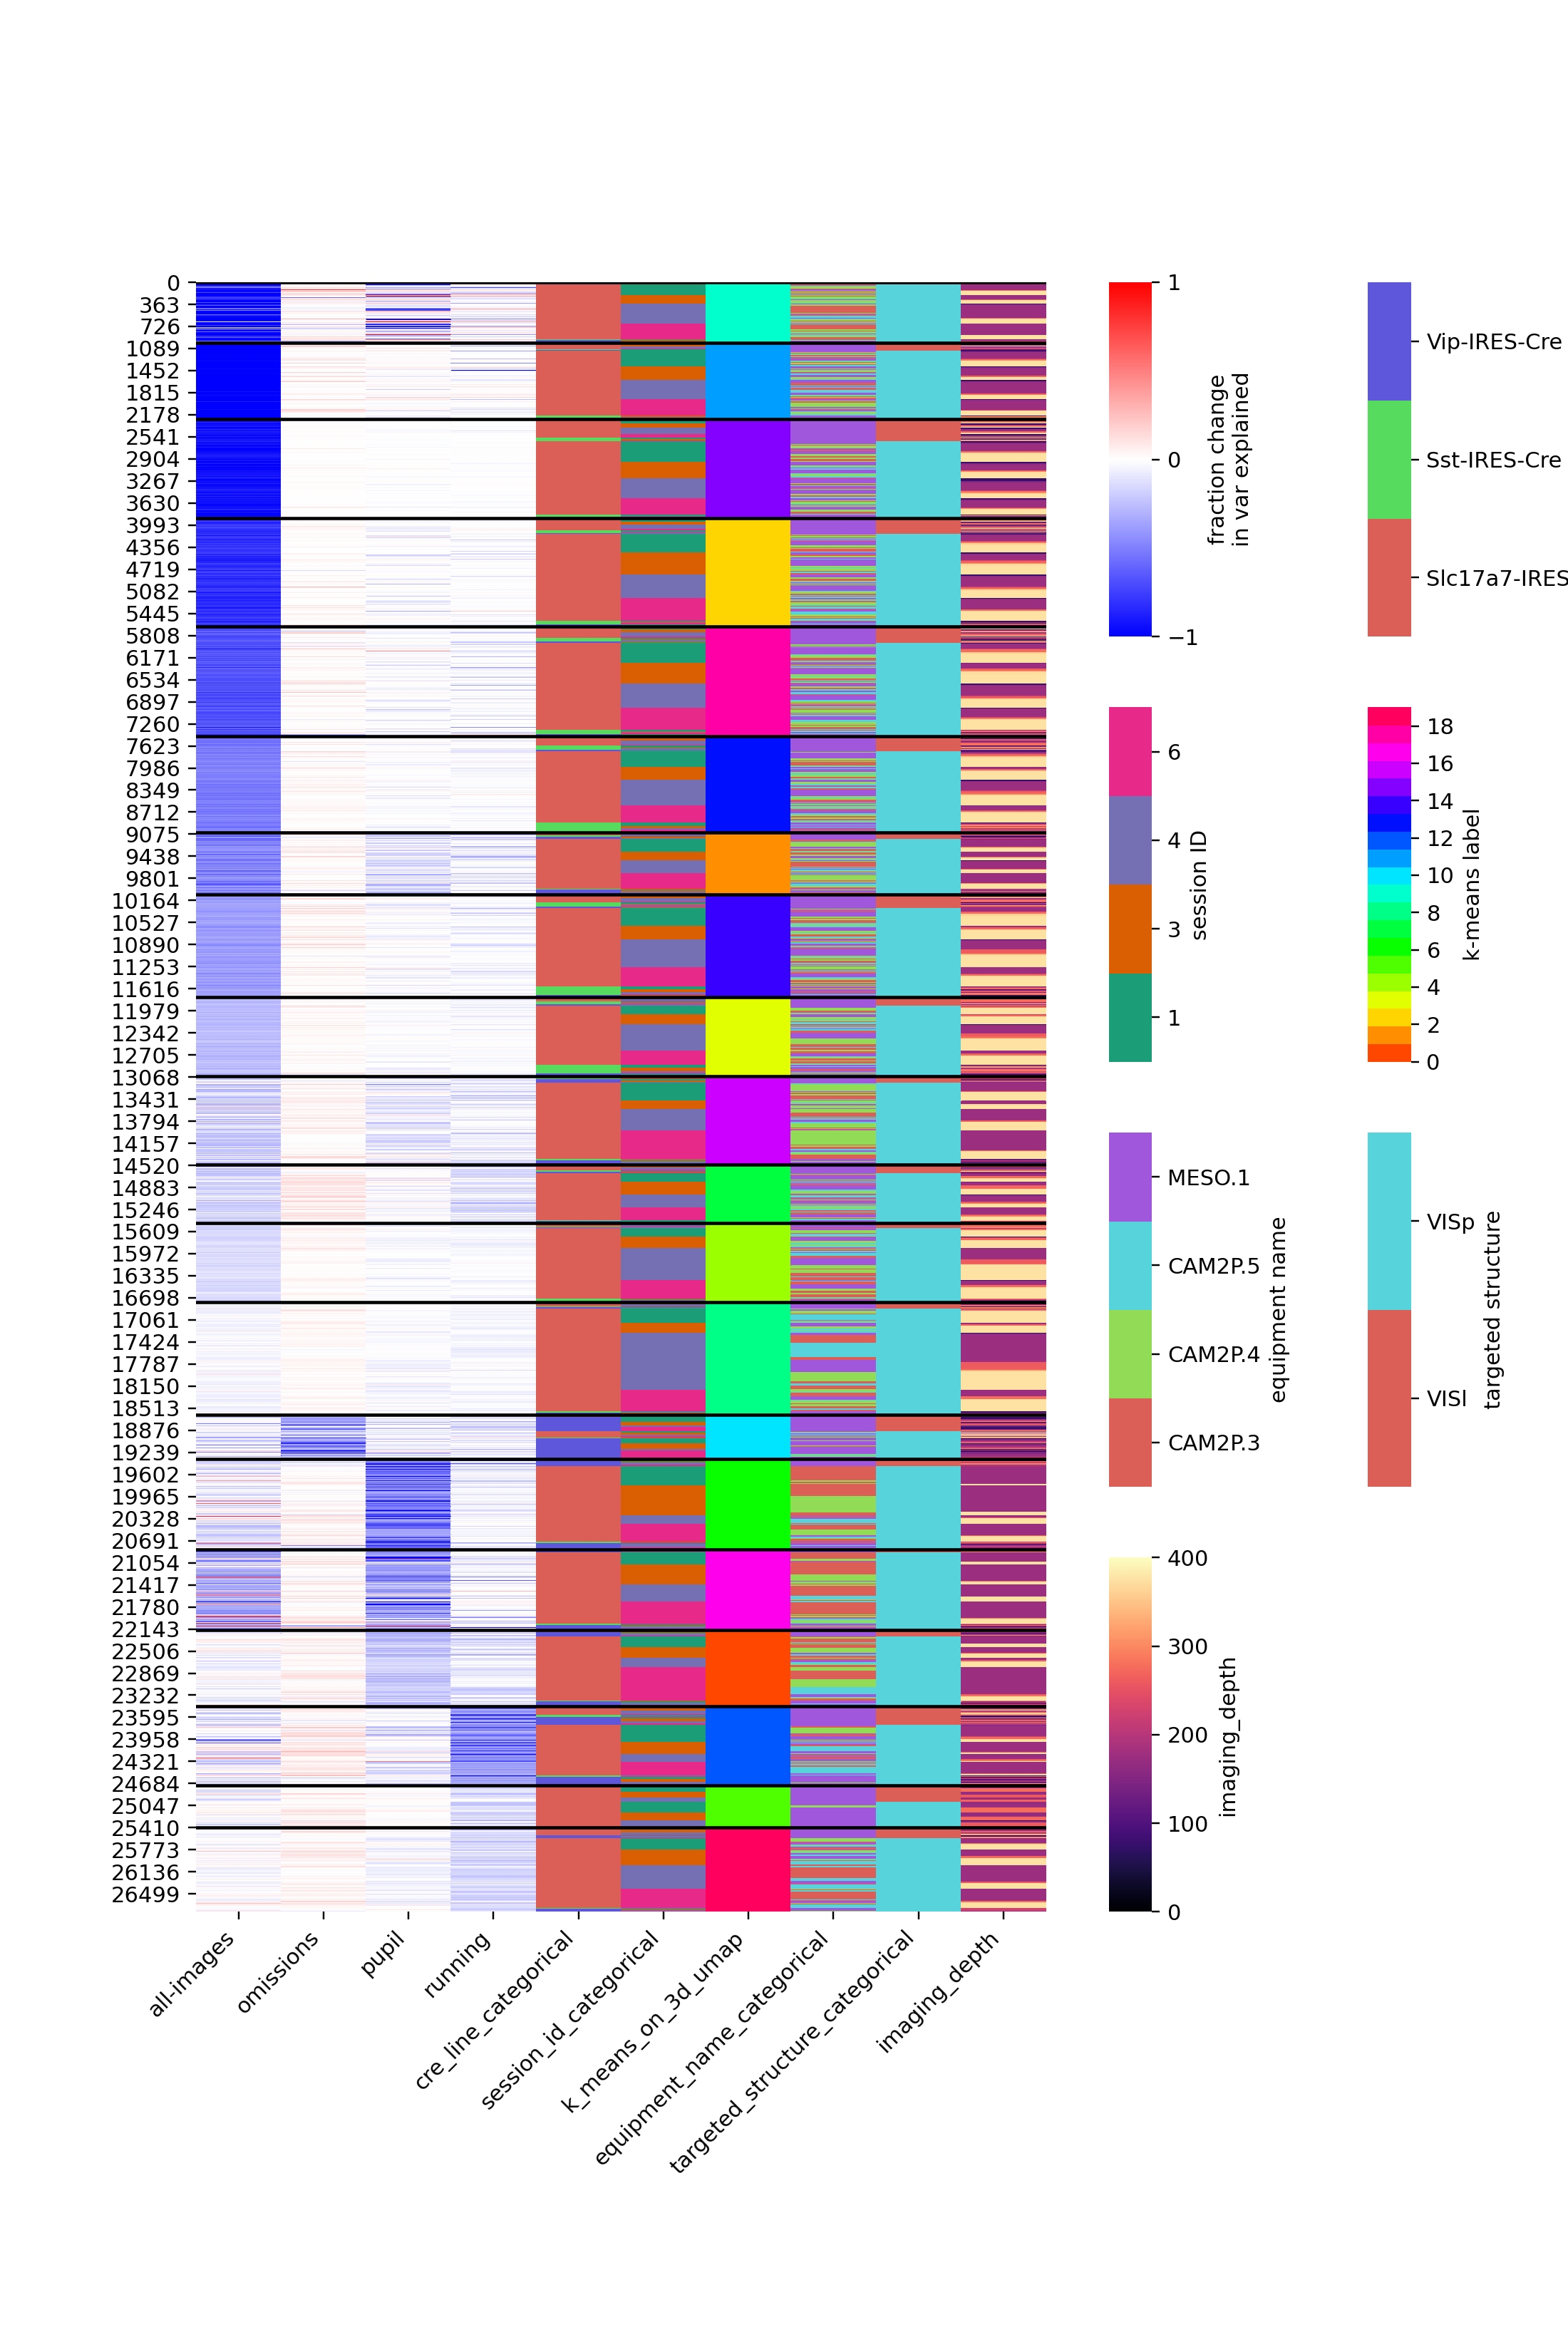

In [42]:
sort_order = ['dominant_dropout','dominant_dropout_median','targeted_structure_categorical','cre_line_categorical','session_id_categorical','imaging_depth']
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,15), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

## Sort by cluster ID and move it to the leftmost column

<IPython.core.display.Javascript object>


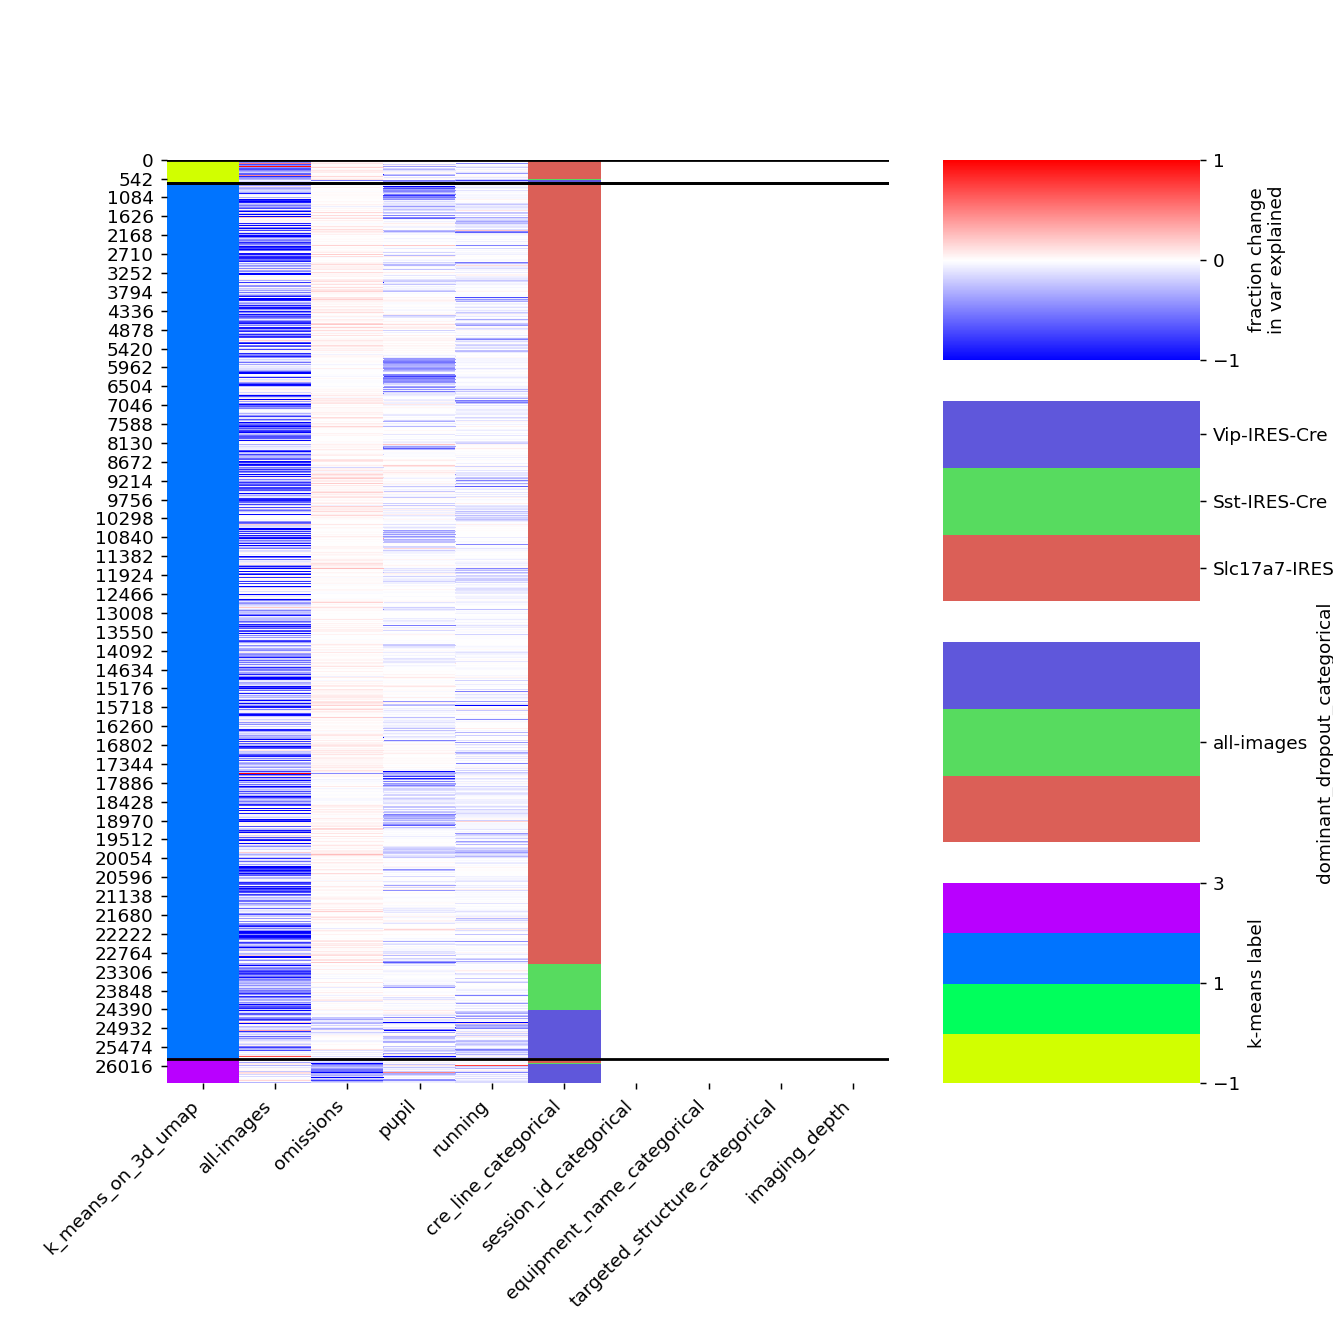

In [169]:
sort_order = ['clusterer_labels','cre_line_categorical','session_id_categorical','imaging_depth']
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='clusterer_labels')

cols_to_plot = [
    'clusterer_labels', 
    'all-images', 
    'omissions', 
    'pupil', 
    'running',
    'cre_line_categorical', 
    'session_id_categorical', 
    'equipment_name_categorical',
    'targeted_structure_categorical',
    'imaging_depth'
]

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,10), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')